# Denoising via Conditional Variational Autoencoder Model

We now evaluate the effectiveness of the CVAE autoencoder as a tool for both denoising
and feature extraction. 

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from preprocess import load_fixedSize, returnEventDistribution, preprocessInputs

### Analyze the data. Consider events ordered by the number of samples we have.
eventDistribution = returnEventDistribution('MU')
print(eventDistribution)

### Where X represents input EEG data, Y represents OHE MNIST labels, and Y_raw
# represents the raw MNIST labels.
feature_size = 476
X, Y, Y_raw = load_fixedSize(feature_size, 'MU')
X = preprocessInputs(X)
feature_size = X.shape[1]
print('Feature Size: ', feature_size)

Reading MU dataset...
OrderedDict([(476, 51272), (460, 44432), (459, 32815), (493, 18504), (442, 9584), (510, 3308), (425, 2208), (527, 728), (408, 312), (544, 224), (561, 52), (474, 40), (461, 32), (438, 16), (468, 16), (478, 16), (457, 12), (472, 12), (497, 12), (470, 12), (467, 12), (492, 12), (473, 12), (464, 12), (479, 12), (480, 12), (465, 12), (490, 12), (456, 12), (446, 8), (506, 8), (495, 8), (463, 8), (444, 8), (477, 8), (462, 8), (485, 8), (475, 8), (454, 8), (491, 8), (443, 8), (484, 8), (471, 8), (452, 4), (486, 4), (449, 4), (578, 4), (482, 4), (508, 4), (458, 4), (488, 4), (483, 4), (469, 4), (455, 4), (440, 4), (439, 4), (501, 4), (536, 4), (612, 4), (450, 4), (481, 4), (453, 4), (487, 4), (448, 4), (524, 4), (445, 4), (451, 4), (498, 4), (509, 4)])
Reading MU dataset...
Preprocessing complete.
Inputs shape: (51272, 476) || Labels shape: (51272, 10)
Feature Size:  476


Once again, we visualize the data before training our CVAE model.

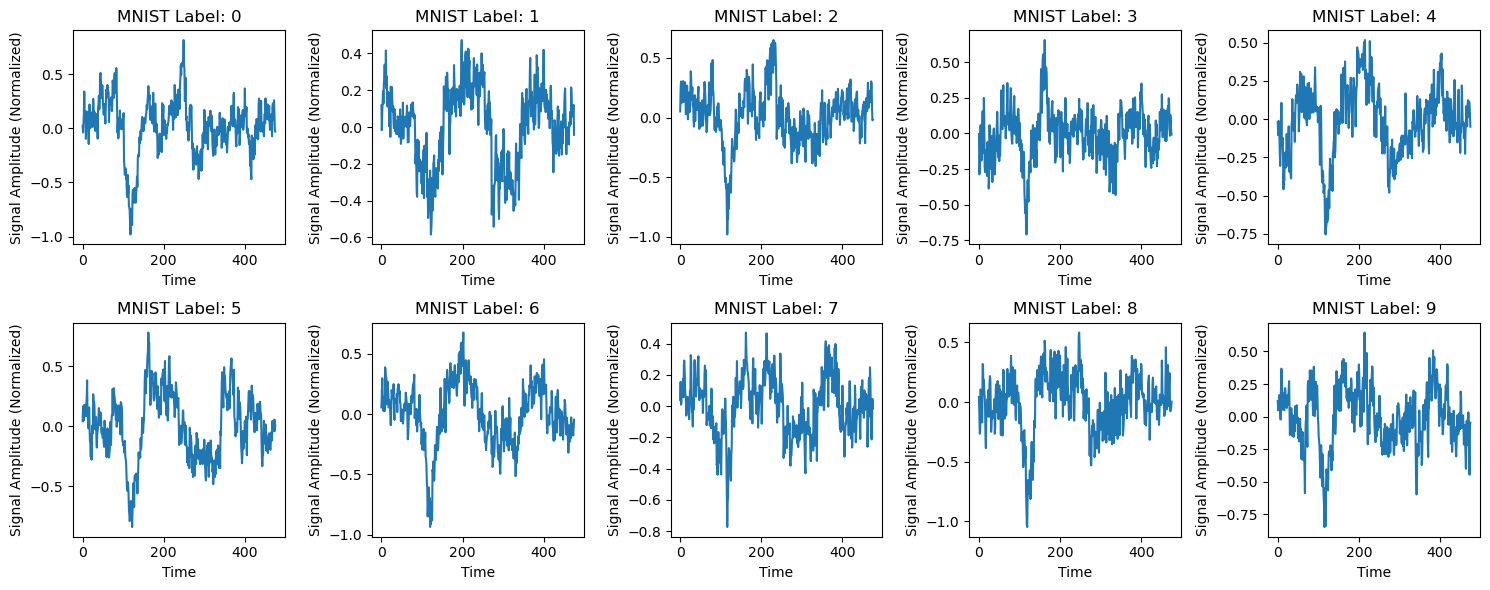

In [3]:
## Sanity Check on Data. 
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

averaged_samples = defaultdict(list)

for signal, label in zip(X, Y_raw):
    averaged_samples[label].append(signal)

# Calculate the average of each label. This is the average signal for each label.
for label, signals in averaged_samples.items():
    averaged_signal = np.mean(signals, axis=0)
    averaged_samples[label] = averaged_signal

# Plot the averaged signals
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    averaged_signal, label = averaged_samples[i], i
    axes[i].plot(averaged_signal)
    axes[i].set_title(f"MNIST Label: {label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal Amplitude (Normalized)")

plt.tight_layout()
plt.show()

Interesting enough, this is the one model type that shares the same train/val/test loader
as the baselines. This is because uniquely in the CVAE, we append the label onto the
latent space vector. To match the format of the other notebook files, we have chosen to
declare two separate loaders to clearly distinct them.

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train, validation, and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
Y_train, Y_val, Y_test = np.float32(Y_train), np.float32(Y_val), np.float32(Y_test)

# Convert the data to PyTorch tensors.
X_train_tensor, X_val_tensor, X_test_tensor = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
Y_train_tensor, Y_val_tensor, Y_test_tensor = torch.from_numpy(Y_train), torch.from_numpy(Y_val), torch.from_numpy(Y_test)

# Create TensorDatasets for train and test sets.
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoader for train and test sets.
batch_size = 8
cvae_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cvae_val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
cvae_test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We define our autoencoder model and train it to reconstruct data.

In [39]:
from models.cvae import CVAE
from torch import optim, nn

### Model Setup
cvae_model = CVAE()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
cvae_model.to(device)

criterion = nn.KLDivLoss()
optimizer = optim.Adam(cvae_model.parameters(), lr=0.0001)

Running on cpu


In [ ]:
### Training Loop
num_epochs = 10
vae_epoch_train_losses = []
vae_epoch_val_losses   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    cvae_model.train()
    for (batchX, batchY) in cvae_train_dataloader:
        # Forward pass
        batchX = batchX[0].to(device)
        outputs = cvae_model(batchX, batchY)
        outputs = outputs.squeeze(1)
        
        # Backward pass
        loss = criterion(outputs, batchX)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    cvae_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in cvae_val_dataloader:
            batchX = batchX[0].to(device)
            outputs = cvae_model(batchX, batchY)
            outputs = outputs.squeeze(1)

            loss = criterion(outputs, batchX)
            epoch_val_loss += loss.item()

    # Save and print losses
    epoch_train_loss /= len(cvae_train_dataloader)
    epoch_val_loss   /= len(cvae_val_dataloader)

    vae_epoch_train_losses.append(epoch_train_loss)
    vae_epoch_val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss}")

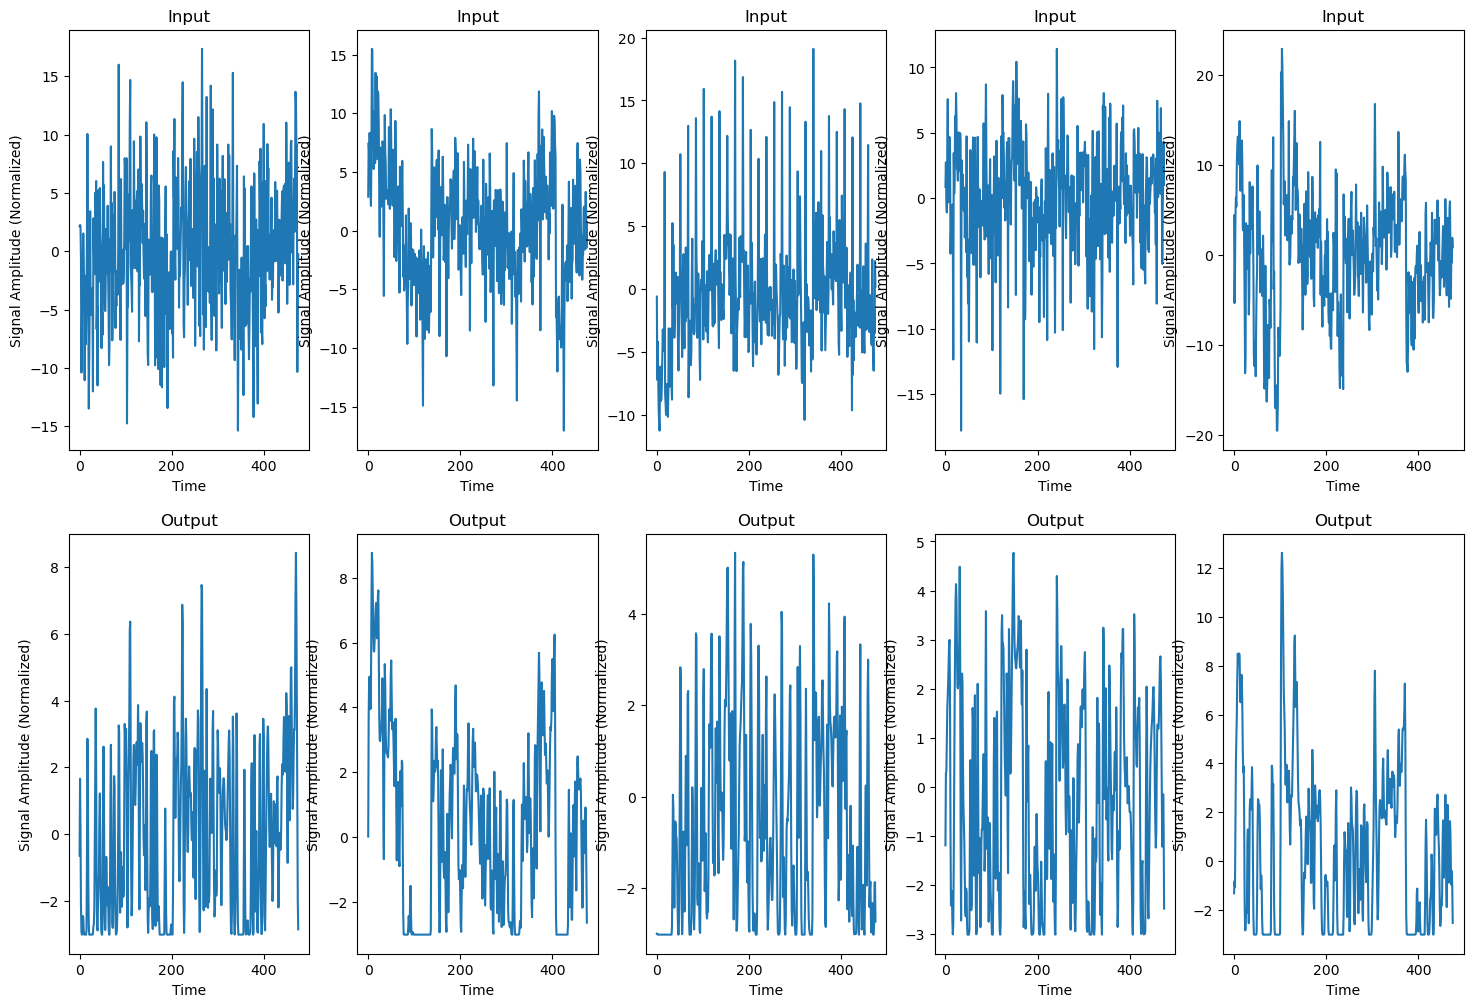

In [25]:
# Select a random sample from the test dataset
import matplotlib.pyplot as plt

# Set the autoencoder model to evaluation mode
cvae_model.eval()

# Select a random sample from the test dataset
sample_indices = np.array([0, 1, 2, 3, 4])
num_samples = len(sample_indices)
fig, axes = plt.subplots(2, num_samples, figsize=(18, 12))

for i, sample_index in enumerate(sample_indices):
    # Select the sample
    sample_input = X_test_tensor[sample_index].unsqueeze(0).to(device)
    sample_label = Y_test_tensor[sample_index].unsqueeze(0).to(device)
    sample_output = cvae_model(sample_input, sample_label)

    # Convert the tensors to numpy arrays
    input_array = sample_input.cpu().detach().numpy()
    output_array = sample_output.cpu().detach().numpy()

    # Reshape the arrays to match the original shape
    input_array = input_array.reshape(-1, feature_size)
    output_array = output_array.reshape(-1, feature_size)

    # Plot the input and output side by side
    axes[0, i].plot(input_array[0])
    axes[0, i].set_title("Input")
    axes[0, i].set_xlabel("Time")
    axes[0, i].set_ylabel("Signal Amplitude (Normalized)")

    axes[1, i].plot(output_array[0])
    axes[1, i].set_title("Output")
    axes[1, i].set_xlabel("Time")
    axes[1, i].set_ylabel("Signal Amplitude (Normalized)")
plt.show()

### Baseline Re-Running

We now re-run our baselines and compare their performance to the original baselines
on the original data.

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train, validation, and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
Y_train, Y_val, Y_test = np.float32(Y_train), np.float32(Y_val), np.float32(Y_test)

# Convert the data to PyTorch tensors.
X_train_tensor, X_val_tensor, X_test_tensor = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
Y_train_tensor, Y_val_tensor, Y_test_tensor = torch.from_numpy(Y_train), torch.from_numpy(Y_val), torch.from_numpy(Y_test)

# Create TensorDatasets for train and test sets.
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoader for train and test sets.
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
from models.baseline import mlp_Baseline
from torch import optim, nn

### Model Setup
mlp_model = mlp_Baseline(feature_size, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

Running on cpu


In [31]:
### Training Loop
num_epochs = 10
mlp_epoch_train_losses = []
mlp_epoch_val_losses   = []
mlp_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    mlp_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        batchX = batchX.to(device)
        outputs = cvae_model(batchX, batchY).to(device)
        outputs = mlp_model(outputs).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        
        # Backward pass
        loss = criterion(outputs, batchY.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    mlp_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            batchX = batchX.to(device)
            outputs = cvae_model(batchX, batchY).to(device)
            outputs = mlp_model(outputs).to(device)
            outputs = torch.squeeze(outputs, dim=1)

            loss = criterion(outputs, batchY.to(device))
            epoch_val_loss += loss.item()

            pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
            for a, b in zip(pred, actual):
                if np.argmax(a) == np.argmax(b):
                    epoch_accuracy += 1 / len(batchX)

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    mlp_epoch_train_losses.append(epoch_train_loss)
    mlp_epoch_val_losses.append(epoch_val_loss)
    mlp_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.3126352784290205 || Validation loss: 2.3079322156221744 || Accuracy: 0.43127925117003835
Epoch 2 Training loss: 2.226247849052124 || Validation loss: 2.241467746718834 || Accuracy: 0.438384733179475
Epoch 3 Training loss: 2.2082630053935035 || Validation loss: 2.178601255864641 || Accuracy: 0.44303656086545407
Epoch 4 Training loss: 2.1944392181094288 || Validation loss: 2.1178245732152887 || Accuracy: 0.44427634158330387
Epoch 5 Training loss: 2.1557200414781885 || Validation loss: 2.0963853319388597 || Accuracy: 0.4513990163114587
Epoch 6 Training loss: 2.0799995486070504 || Validation loss: 2.0302914736002027 || Accuracy: 0.4524162329982159
Epoch 7 Training loss: 2.05123158319683 || Validation loss: 1.9408880102160715 || Accuracy: 0.4550210036251268
Epoch 8 Training loss: 1.96575066213625 || Validation loss: 1.8520767269286256 || Accuracy: 0.46404346309876765
Epoch 9 Training loss: 1.952198045731565 || Validation loss: 1.8163726593157699 || Accuracy: 0.47119

/opt/anaconda3/envs/hack@brown/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


The test accuracy is: 0.4414892729181


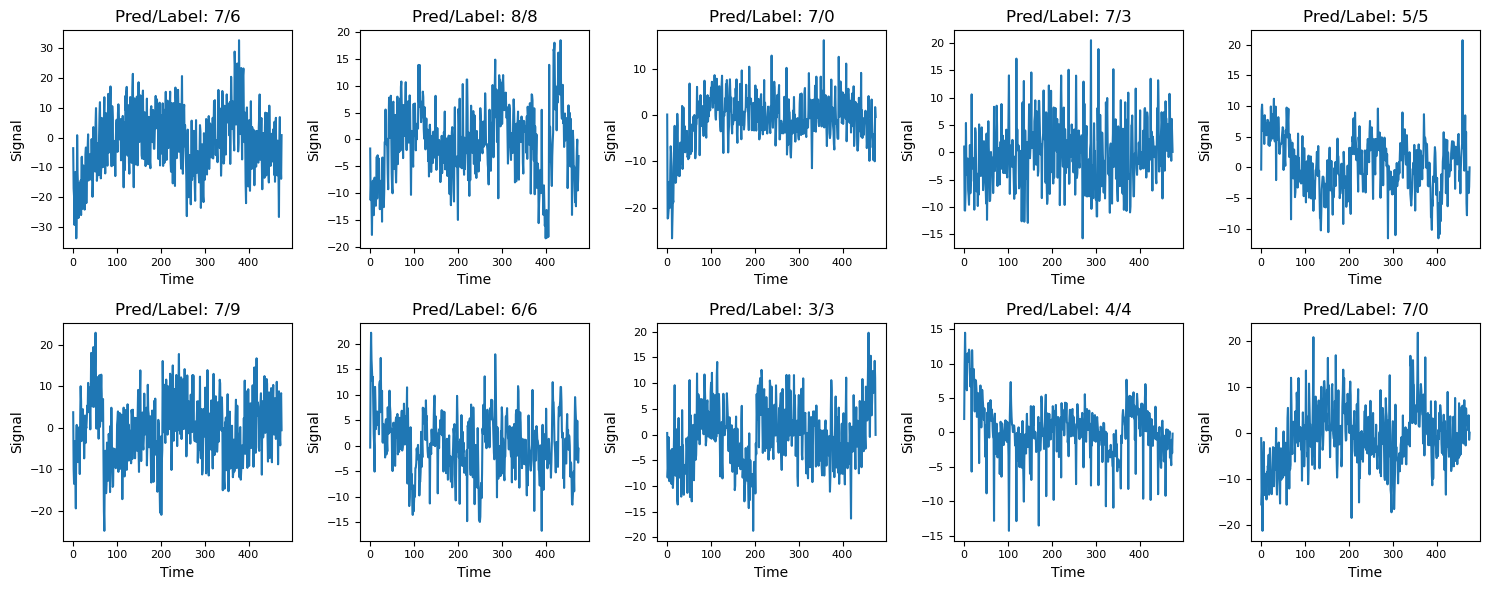

In [40]:
# Set the MLP model to evaluation mode
mlp_model.eval()

acc = 0
with torch.no_grad():
    for (batchX, batchY) in test_dataloader:
        outputs = cvae_model(batchX.to(device), batchY.to(device)).to(device)
        outputs = mlp_model(outputs).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        loss = criterion(outputs, batchY.to(device))
        epoch_val_loss += loss.item()

        pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
        for a, b in zip(pred, actual):
            if np.argmax(a) == np.argmax(b):
                acc += 1
print(f"The test accuracy is: {acc / len(X_test_tensor)}")

# Define the indices to plot
indices = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over the indices and plot the samples
for i, index in enumerate(indices):
    # Select the sample from the test dataset
    sample_input = X_test_tensor[index].unsqueeze(0).to(device)
    sample_label = Y_test_tensor[index]

    # Pass the sample through the MLP model
    sample_input = cvae_model(sample_input, sample_label).to(device)
    sample_output = mlp_model(sample_input).to(device)

    # Convert the tensors to numpy arrays
    input_array = sample_input.cpu().detach().numpy()
    output_array = sample_output.cpu().detach().numpy()

    # Reshape the arrays to match the original shape
    input_array = input_array.reshape(-1, feature_size)
    output_array = output_array.reshape(-1, 10)

    # Get the predicted and actual labels
    predicted_label = np.argmax(output_array)
    actual_label = np.argmax(sample_label)

    # Plot the input signal with predicted and actual labels
    axes[i].plot(input_array[0])
    axes[i].set_title(f"Pred/Label: {predicted_label}/{actual_label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal")
    axes[i].tick_params(axis='both', which='both', labelsize=8)
    
plt.tight_layout()
plt.show()

In [23]:
### Model Setup
from models.baseline import rnn_Baseline

rnn_model = rnn_Baseline(128, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

Running on cpu


In [29]:
### Training Loop
num_epochs = 10
rnn_epoch_train_losses = []
rnn_epoch_val_losses   = []
rnn_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    mlp_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        batchX = batchX.to(device)
        outputs = cvae_model(batchX, batchY).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        outputs = rnn_model(outputs).to(device)
        
        # Backward pass
        loss = criterion(outputs, batchY.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    mlp_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            batchX = batchX.to(device)
            outputs = cvae_model(batchX, batchY).to(device)
            outputs = torch.squeeze(outputs, dim=1)
            outputs = rnn_model(outputs).to(device)

            loss = criterion(outputs, batchY.to(device))
            epoch_val_loss += loss.item()

            pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
            for a, b in zip(pred, actual):
                if np.argmax(a) == np.argmax(b):
                    epoch_accuracy += 1 / len(batchX)

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    rnn_epoch_train_losses.append(epoch_train_loss)
    rnn_epoch_val_losses.append(epoch_val_loss)
    rnn_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")


Epoch 1 Training loss: 2.306012701318714 || Validation loss: 2.3173511450450617 || Accuracy: 0.7598712948517793
Epoch 2 Training loss: 2.25128246276091 || Validation loss: 2.252029966865017 || Accuracy: 0.7764421993046065
Epoch 3 Training loss: 2.2039935231075107 || Validation loss: 2.1867770139775478 || Accuracy: 0.7942332358055556
Epoch 4 Training loss: 2.1601264314005975 || Validation loss: 2.173073395590141 || Accuracy: 0.8107159838814854
Epoch 5 Training loss: 2.1062201286701456 || Validation loss: 2.0855836808587593 || Accuracy: 0.829995667712799
Epoch 6 Training loss: 2.014573769596696 || Validation loss: 2.049286718631424 || Accuracy: 0.8466159851854579
Epoch 7 Training loss: 1.97363255812761 || Validation loss: 2.005453399260196 || Accuracy: 0.8630450803927054
Epoch 8 Training loss: 1.956954776975281 || Validation loss: 1.9947384346620174 || Accuracy: 0.8766800192577179
Epoch 9 Training loss: 1.9327176366634646 || Validation loss: 1.951151086053167 || Accuracy: 0.8890008982117

The test accuracy is: 0.87911994672926


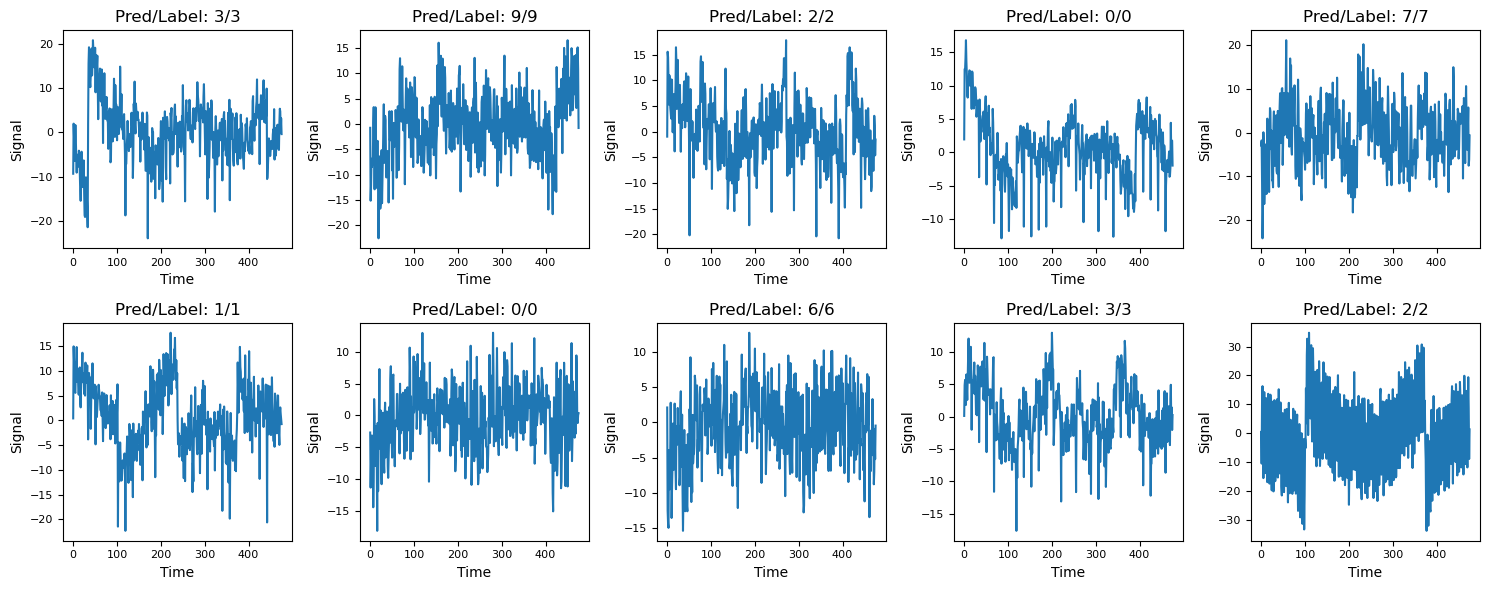

In [33]:
# Set the MLP model to evaluation mode
rnn_model.eval()

acc = 0
with torch.no_grad():
    for (batchX, batchY) in test_dataloader:
        outputs = cvae_model(batchX.to(device), batchY.to(device)).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        outputs = mlp_model(outputs).to(device)
        
        loss = criterion(outputs, batchY.to(device))
        epoch_val_loss += loss.item()

        pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
        for a, b in zip(pred, actual):
            if np.argmax(a) == np.argmax(b):
                acc += 1
print(f"The test accuracy is: {acc / len(X_test_tensor)}")

# Define the indices to plot
indices = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over the indices and plot the samples
for i, index in enumerate(indices):
    # Select the sample from the test dataset
    sample_input = X_test_tensor[index].unsqueeze(0).to(device)
    sample_label = Y_test_tensor[index]

    # Pass the sample through the MLP model
    sample_input = cvae_model(sample_input, sample_label).to(device)
    sample_output = rnn_model(sample_input).to(device)

    # Convert the tensors to numpy arrays
    input_array = sample_input.cpu().detach().numpy()
    output_array = sample_output.cpu().detach().numpy()

    # Reshape the arrays to match the original shape
    input_array = input_array.reshape(-1, feature_size)
    output_array = output_array.reshape(-1, 10)

    # Get the predicted and actual labels
    predicted_label = np.argmax(output_array)
    actual_label = np.argmax(sample_label)

    # Plot the input signal with predicted and actual labels
    axes[i].plot(input_array[0])
    axes[i].set_title(f"Pred/Label: {predicted_label}/{actual_label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal")
    axes[i].tick_params(axis='both', which='both', labelsize=8)
    
plt.tight_layout()
plt.show()